# Use Pandas to Sort event arrivals csv files

##  Fei Zhang
### 2018-07-12

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SOURCE_LATITUDE = 'source_latitude'
SOURCE_LONGITUDE = 'source_longitude'
STATION_LATITUDE = 'station_latitude'
STATION_LONGITUDE = 'station_longitude'
STATION_CODE = 'station_code'
FREQUENCY = 'no_of_summary_rays'

column_names = ['source_block', 'station_block',
                'residual', 'event_number',
                SOURCE_LONGITUDE, SOURCE_LATITUDE,
                'source_depth', STATION_LONGITUDE, STATION_LATITUDE,
                'observed_tt', 'locations2degrees', STATION_CODE, 'P_or_S']

def sort(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on median of observed travel time.

    If there are multiple source and station block combinations, we keep the
    row corresponding to the median observed travel time (observed_tt).

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: None
    """

#     log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    #cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

#     log.info('Sorting arrivals.')

    # groupby automatically sorts
    med = cluster_data.groupby(by=['source_block',
                                   'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block',
                                     'event_number', SOURCE_LONGITUDE,
                                     SOURCE_LATITUDE, 'source_depth'],
                             keep='first',
                             inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df


In [3]:
!pwd


/g/data1a/ha3/fxz547/Githubz/passive-seismic/notebooks


In [4]:

# inputcsv='/g/data1a/ha3/fxz547/travel_time_tomography/run5_events_1deg/outfile_S.csv'
# residual_cutoff=10.0
# sortedfile='sortedfile_S.csv'
# sortedfile2= 'sortedfile2_S.csv'

inputcsv='/g/data1a/ha3/fxz547/travel_time_tomography/run5_events_1deg/outfile_P.csv'
residual_cutoff=5.0
sortedfile='sortedfile_P.csv'
sortedfile2= 'sortedfile2_P.csv'


In [5]:
finalpdf = sort(inputcsv,sortedfile,residual_cutoff)

In [6]:
finalpdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,P_or_S
3975289,1122,9214,-0.9,4138020,40.8792,87.0653,0.0,-146.887,64.7707,353.972295,28.139693,ILAR,1
3975290,1122,15563,0.2,4138020,40.8792,87.0653,0.0,82.290,46.7931,466.488392,41.042857,MKAR,1
3975291,1122,18963,0.6,4138020,40.8792,87.0653,0.0,-118.304,38.4293,569.977076,54.320942,NVAR,1
3975292,1122,22217,0.3,4138020,40.8792,87.0653,0.0,-103.667,29.3331,630.227493,63.071005,TXAR,1
3975293,1122,27723,-0.6,4138020,40.8792,87.0653,0.0,1.695,13.1470,700.339917,74.585736,TORD,1


In [7]:
#sort again
pdf2=sort(sortedfile, sortedfile2, residual_cutoff )

In [8]:
pdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,P_or_S
0,1122,9214,-0.9,4138020,40.8792,87.0653,0.0,-146.887,64.7707,353.972295,28.139693,ILAR,1
1,1122,15563,0.2,4138020,40.8792,87.0653,0.0,82.290,46.7931,466.488392,41.042857,MKAR,1
2,1122,18963,0.6,4138020,40.8792,87.0653,0.0,-118.304,38.4293,569.977076,54.320942,NVAR,1
3,1122,22217,0.3,4138020,40.8792,87.0653,0.0,-103.667,29.3331,630.227493,63.071005,TXAR,1
4,1122,27723,-0.6,4138020,40.8792,87.0653,0.0,1.695,13.1470,700.339917,74.585736,TORD,1


In [9]:
pdf2.shape

(3278317, 13)

<Figure size 432x288 with 0 Axes>

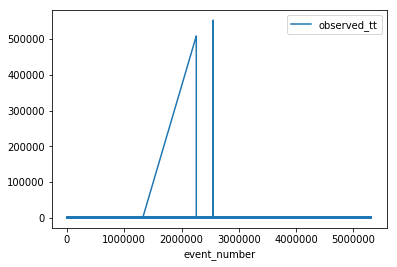

In [10]:
plt.figure(); pdf2.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

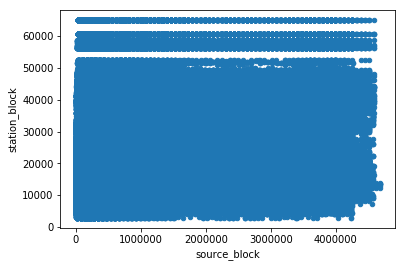

In [11]:
plt.figure(); pdf2.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

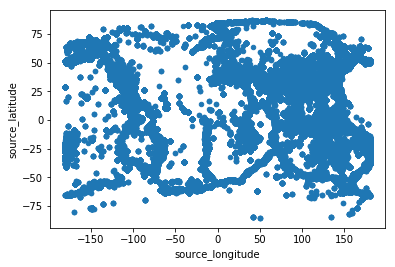

In [12]:
plt.figure(); pdf2.plot.scatter(x='source_longitude', y='source_latitude')

<Figure size 432x288 with 0 Axes>

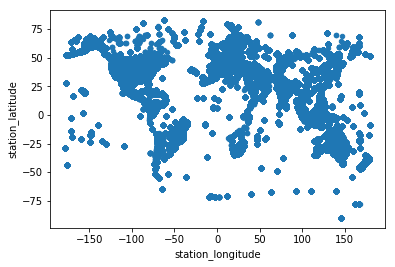

In [13]:
plt.figure(); pdf2.plot.scatter(x='station_longitude', y='station_latitude')

In [14]:
 med = pdf2.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

In [15]:
med.head()

,source_block,station_block,observed_tt
0,1122,9214,353.972295
1,1122,15563,466.488392
2,1122,18963,569.977076
3,1122,22217,630.227493
4,1122,27723,700.339917


In [16]:
med.shape

(3162982, 3)

In [17]:
pdf2.shape

(3278317, 13)

In [18]:
pdf3=pdf2.groupby(by=['source_block', 'station_block']).count()

In [19]:
pdf3.shape

(3162982, 11)

In [20]:
pdf4=pdf3[(pdf3['residual']>2)]

In [21]:
pdf4.shape

(152, 11)

In [22]:
pdf4.tail()

residual  event_number  source_longitude  \
source_block station_block                                             
149425       37829                 3             3                 3   
             38473                 3             3                 3   
             39259                 3             3                 3   
             41427                 3             3                 3   
             42866                 3             3                 3   

                            source_latitude  source_depth  station_longitude  \
source_block station_block                                                     
149425       37829                        3             3                  3   
             38473                        3             3                  3   
             39259                        3             3                  3   
             41427                        3             3                  3   
             42866                        3             3                  3   

                            station_latitude  observed_tt  locations2degrees  \
source_block station_block                                                     
149425       37829                         3            3                  3   
             38473                         3            3                  3   
             39259                         3            3                  3   
             41427                         3            3                  3   
             42866                         3            3                  3   

                            station_code  P_or_S  
source_block station_block                        
149425       37829                     3       3  
             38473                     3       3  
             39259                     3       3  
             41427                     3       3  
             42866                     3       3

In [23]:
# select rows
rowmask= (pdf2['source_block'] == 9344) & (pdf2['station_block']==9037)  #select certain rows
pdf5=pdf2.loc[ rowmask ]

In [24]:
pdf5.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,P_or_S
3879,9344,9037,-1.9,766042,-17.4868,64.6856,2156.0,35.702,65.0276,293.694471,21.932159,SLVR,1


In [25]:
rowmask = (pdf2['source_block'] ==149425) & (pdf2['station_block']==18461)  #select rows where cond
pdf2.loc[ rowmask ].head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,P_or_S
824132,149425,18461,-0.5,3501026,24.4912,34.8541,23565.0,99.814,39.4097,594.248068,58.435318,GTA,1
824133,149425,18461,-0.5,3220032,24.4912,34.8541,23565.0,99.814,39.4097,594.248068,58.435318,GTA,1
824134,149425,18461,-0.5,4196052,24.4912,34.8541,23565.0,99.814,39.4097,594.248068,58.435318,GTA,1


In [26]:
unikpdf2=pdf2.drop_duplicates(subset=['source_block', 'station_block'], keep='first')

In [27]:
unikpdf2.shape

(3162982, 13)

In [28]:
pdf2.shape

(3278317, 13)

#  Modify the sort function

In [29]:
import logging

log = logging.getLogger(__name__)

# def sort(output_file, sorted_file, residual_cutoff):
def sort2(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on best Signal_to_Noise-Ratio seismic wave: If there are multiple source and station block combinations, we keep the
    row corresponding to the highest SNR value

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: pandas_df
    """

    log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    #cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

    log.info('Sorting arrivals.')

    # groupby automatically sorts
    med = cluster_data.groupby(
        by=['source_block', 'station_block']
        )['observed_tt'].quantile(q=.5, interpolation='lower').reset_index() # use a seq index:0,1,2,....

    # med dataframe has three columns:  [source_block, station_block ,observed_tt]
    
    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block'],
                             keep='first',  inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df

In [30]:
mypdf = sort2(inputcsv,sortedfile,residual_cutoff)

In [31]:
mypdf.shape

(3162982, 13)

In [32]:
mypdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,P_or_S
3975289,1122,9214,-0.9,4138020,40.8792,87.0653,0.0,-146.887,64.7707,353.972295,28.139693,ILAR,1
3975290,1122,15563,0.2,4138020,40.8792,87.0653,0.0,82.290,46.7931,466.488392,41.042857,MKAR,1
3975291,1122,18963,0.6,4138020,40.8792,87.0653,0.0,-118.304,38.4293,569.977076,54.320942,NVAR,1
3975292,1122,22217,0.3,4138020,40.8792,87.0653,0.0,-103.667,29.3331,630.227493,63.071005,TXAR,1
3975293,1122,27723,-0.6,4138020,40.8792,87.0653,0.0,1.695,13.1470,700.339917,74.585736,TORD,1


In [33]:
# check if any duplicate (source_block,station_block) in the dataframe?  primkey
mypdf3=mypdf.groupby(by=['source_block', 'station_block']).count()

In [34]:
mypdf3.head()

residual  event_number  source_longitude  \
source_block station_block                                             
1122         9214                  1             1                 1   
             15563                 1             1                 1   
             18963                 1             1                 1   
             22217                 1             1                 1   
             27723                 1             1                 1   

                            source_latitude  source_depth  station_longitude  \
source_block station_block                                                     
1122         9214                         1             1                  1   
             15563                        1             1                  1   
             18963                        1             1                  1   
             22217                        1             1                  1   
             27723                        1             1                  1   

                            station_latitude  observed_tt  locations2degrees  \
source_block station_block                                                     
1122         9214                          1            1                  1   
             15563                         1            1                  1   
             18963                         1            1                  1   
             22217                         1            1                  1   
             27723                         1            1                  1   

                            station_code  P_or_S  
source_block station_block                        
1122         9214                      1       1  
             15563                     1       1  
             18963                     1       1  
             22217                     1       1  
             27723                     1       1

In [35]:
mypdf4 = mypdf3[(mypdf3['residual']>1)]

In [36]:
# check if any duplicate (source_block,station_block)
mypdf4.shape  # no rows now  


(0, 11)